#### Check if GPU is available
Please note that GPU will be required to train your model here. If you are running this in gsds server, follow the instruction below. You will have to use a command "launch-jupyter" to run jupyter notebook with GPU.

For those of you who received gsds server accounts for this class, use "class2" for your slurm partition.

https://gsds.gitbook.io/gsds/for-beginners/slurm

In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


#### Install Requried Packages if not installed in your environment

In [2]:
!pip install datasets
!pip install transformers

#### Run this cell before you start

In [3]:
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Pix2StructProcessor
from torch.utils.data import Dataset, DataLoader

# 2. Fine-tune a pre-trained Image-to-Text model for Image Captioning

In this problem, you will load a pre-trained model, *pix2struct*, and fine-tune it to perform an image captioning task.

Pix2Struct is a pretrained image-to-text model for visual language understanding, and it has been fine-tuned on a variety of tasks and datasets, including image captioning and visual question answering. It is pretrained by learning to parse masked screenshots of web pages into simplified HTML. For more details about this model, please refer to the paper [here](https://arxiv.org/abs/2210.03347).

We will use a image captioning dataset from Hugging Face to fine-tune the model. The dataset contains Pokémon images with captions.

**(a)** Load the image captioning dataset. Split the data into training and validation set. **(4 pts)**

In [4]:
data_path = "lambdalabs/pokemon-blip-captions"

### YOUR CODE HERE (~4 lines)
### TODO:
### 1. Load dataset from the given data_path
### 2. Spit the dataset into train and validation set (10% will be used for our valid set) and save in 'train_set' and 'valid_set'
### Hint: use load_dataset and train_test_split. You can refer to the following document for 'datasets' library
### https://pypi.org/project/datasets/

# 1. Load dataset from the given data_path
dataset = load_dataset(data_path)

# 2. Split the dataset into train and validation set (10% will be used for our valid set)
split = dataset['train'].train_test_split(test_size=0.1)
train_set = split['train']
valid_set = split['test']

### END YOUR CODE

a gray and white pokemon ball with blue eyes


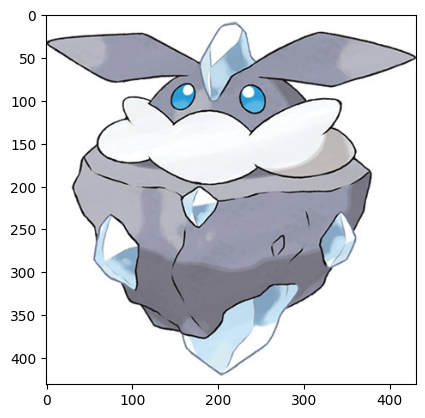

In [5]:
# If you run this cell, you will see a sample data in your training set.
print(train_set[0]["text"])
plt.imshow(train_set[0]["image"])

a drawing of a woman standing next to a giant animal


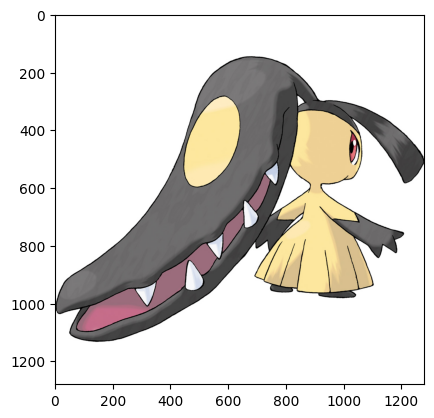

In [6]:
# If you run this cell, you will see a sample data in your validation set.

print(valid_set[0]["text"])
plt.imshow(valid_set[0]["image"])

### Pre-processing
DO NOT modify the code below for data preprocessing

In [7]:
MAX_PATCHES = 16

class ICDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt",
                                  add_special_tokens=True, max_patches=MAX_PATCHES)
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding


class my_collate(object):
    def __init__(self, processor, max_length):
        self.processor = processor
        self.max_length = max_length

    def __call__(self, batch):
       new_batch = {"flattened_patches":[], "attention_mask":[]}
       texts = [item["text"] for item in batch]

       text_inputs = self.processor(text=texts, padding="max_length", return_tensors="pt",
                                add_special_tokens=True, max_length=self.max_length)
       new_batch["labels"] = text_inputs.input_ids

       for item in batch:
          new_batch["flattened_patches"].append(item["flattened_patches"])
          new_batch["attention_mask"].append(item["attention_mask"])

       new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
       new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

       return new_batch


In [8]:
# DO NOT modify below hyperparameters.
max_length = 20
batch_size = 2
model_path = "google/pix2struct-base"

processor = Pix2StructProcessor.from_pretrained(model_path)
my_collate_fn = my_collate(processor, max_length)

train_dataset = ICDataset(train_set, processor)
valid_dataset = ICDataset(valid_set, processor)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size, collate_fn=my_collate_fn)

sample_data = next(iter(train_loader))
print("Total number of training data :", len(train_loader.dataset))
print("Total number of test data :", len(valid_loader.dataset))
print("Flattened patches size: ", sample_data['flattened_patches'].size())
print("Attention mask size: ", sample_data['attention_mask'].size())
print("Label size: ", sample_data['labels'].size())

Total number of training data : 749
Total number of test data : 84
Flattened patches size:  torch.Size([2, 16, 770])
Attention mask size:  torch.Size([2, 16])
Label size:  torch.Size([2, 20])


### Load model and prepare for fine-tuning

In [9]:
# DO NOT modify below hyperparameters.
LEARNING_RATE = 1e-5
model_path = "google/pix2struct-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Pix2StructForConditionalGeneration.from_pretrained(model_path)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print("Device :", device)   # cuda
print(model)

Device : cpu
Pix2StructForConditionalGeneration(
  (encoder): Pix2StructVisionModel(
    (embeddings): Pix2StructVisionEmbeddings(
      (patch_projection): Linear(in_features=768, out_features=768, bias=True)
      (row_embedder): Embedding(4096, 768)
      (column_embedder): Embedding(4096, 768)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): Pix2StructVisionEncoder(
      (layer): ModuleList(
        (0-11): 12 x Pix2StructVisionLayer(
          (attention): Pix2StructVisionAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (output): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): Pix2StructVisionMlp(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048, 

### Fine-tuning

Next, we will fine-tune the model to our dataset. Complete the train and evaluation code following the instruction in jupyter notebook file. It will take about 1 hour to train your model.

**(b)** Complete the training code in `train()` function of Trainer class. **(10 pts)**

**(c)** Complete the validation code in `train()` function of Trainer class. **(6 pts)**

**(d)** After the training is complete, use the `plot()` function of Trainer class to display the figure, and then paste it to your latex file. **(6 pts)**

**(e)** Based on your training results in (d), evaluate whether the training was successful, and write at least two ways to improve the model’s performance. **(4 pts)**

In [10]:
from tqdm.auto import tqdm

In [11]:
class Trainer():
    def __init__(self, model, train_loader, valid_loader, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.optimizer = optimizer
        self.epoch_train_loss, self.epoch_val_loss = [], []

    def train(self, epochs):
        if self.epoch_train_loss:
            self.epoch_train_loss, self.epoch_val_loss = [], []

        for epoch in range(epochs):
            ########### TRAIN ###########
            self.model.train()
            train_losses = []
            # for i, batch in enumerate(self.train_loader):
            for batch in tqdm(self.train_loader):
                ### YOUR CODE HERE (~9 lines)
                ### TODO:
                ###     1. Perform a forward pass on the loaded model.
                ###     2. Calculate the loss and perform backpropagation.
                ###     3. Save your loss in train_loss in float type.
                ###     4. Update the model's parameters using the optimizer.
                ### Hint: for input parameters of the model, refer to the below link. you can also check what's included in your batch in above cells.
                ###       https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/pix2struct#transformers.Pix2StructForConditionalGeneration
                ### Hint: we can compute loss as we have 'labels' in our batch.

                # Move batch to the same device as model
                batch = {k: v.to(self.model.device) for k, v in batch.items()}

                # Forward pass
                outputs = self.model(**batch)
                loss = outputs.loss

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Save the loss
                train_loss = loss.item()

                ### END YOUR CODE
                train_losses.append(train_loss)


            ######### VALIDATION #########
            val_losses = []
            self.model.eval()
            # for i, batch in enumerate(self.valid_loader):
            for batch in tqdm(self.valid_loader):
                ### YOUR CODE HERE (~6 lines)
                ### TODO:
                ###     1. Perform a forward pass on the loaded model.
                ###     2. Calculate the loss and save your loss in val_loss in float type.
                ### Hint: use the same approach you made in the previous question to get output and loss
                # Move batch to the same device as model
                batch = {k: v.to(self.model.device) for k, v in batch.items()}

                # Forward pass
                outputs = self.model(**batch)
                loss = outputs.loss

                # Save the loss
                val_loss = loss.item()

                ### END YOUR CODE
                val_losses.append(val_loss)

            ### DO NOT modify below codes
            train_loss = np.mean(train_losses)
            val_loss = np. mean(val_losses)
            self.epoch_train_loss.append(train_loss)
            self.epoch_val_loss.append(val_loss)
            print(f'Epoch {epoch+1}')
            print(f'train_loss : {train_loss} val_loss : {val_loss}')

    def plot(self):
        fig = plt.figure(figsize = (20, 6))
        plt.plot(self.epoch_train_loss, label='Train loss')
        plt.plot(self.epoch_val_loss, label='Validation loss')
        plt.title("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def inference(self, image, processor):
        MAX_PATCHES=16
        device = "cuda" if torch.cuda.is_available() else "cpu"

        encoding = processor(images=image, return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
        encoding = encoding.to(device)

        flattened_patches = encoding['flattened_patches']
        attention_mask = encoding['attention_mask']

        generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
        return generated_caption

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1
train_loss : 15.561665111541748 val_loss : 5.184987545013428


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2
train_loss : 4.8551162865956625 val_loss : 3.07302877448854


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3
train_loss : 2.574682211558024 val_loss : 1.625012633346376


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4
train_loss : 1.5828184728622436 val_loss : 1.0395774713584356


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5
train_loss : 1.3085110419591268 val_loss : 0.9657186198802221


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6
train_loss : 1.1962416437466938 val_loss : 0.9173963275693712


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7
train_loss : 1.1387775552272796 val_loss : 0.8951394387653896


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8
train_loss : 1.0897737052440644 val_loss : 0.874410500838643


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9
train_loss : 1.053115397453308 val_loss : 0.8415531927631015


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10
train_loss : 1.02716969927152 val_loss : 0.8233519515820912


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11
train_loss : 0.9860119922161102 val_loss : 0.8100042754695529


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12
train_loss : 0.9623696550528208 val_loss : 0.8075231122119086


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13
train_loss : 0.9300742878913879 val_loss : 0.801094535560835


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14
train_loss : 0.9219379511674245 val_loss : 0.8017582524390447


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15
train_loss : 0.9151427416006724 val_loss : 0.7903473320461455


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 16
train_loss : 0.8787457024256389 val_loss : 0.7871596316496531


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17
train_loss : 0.8750995356241862 val_loss : 0.7945243027948198


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 18
train_loss : 0.8605472586552302 val_loss : 0.77053283509754


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19
train_loss : 0.8463729564746221 val_loss : 0.7710009089538029


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20
train_loss : 0.8385866520404816 val_loss : 0.7601668217352459


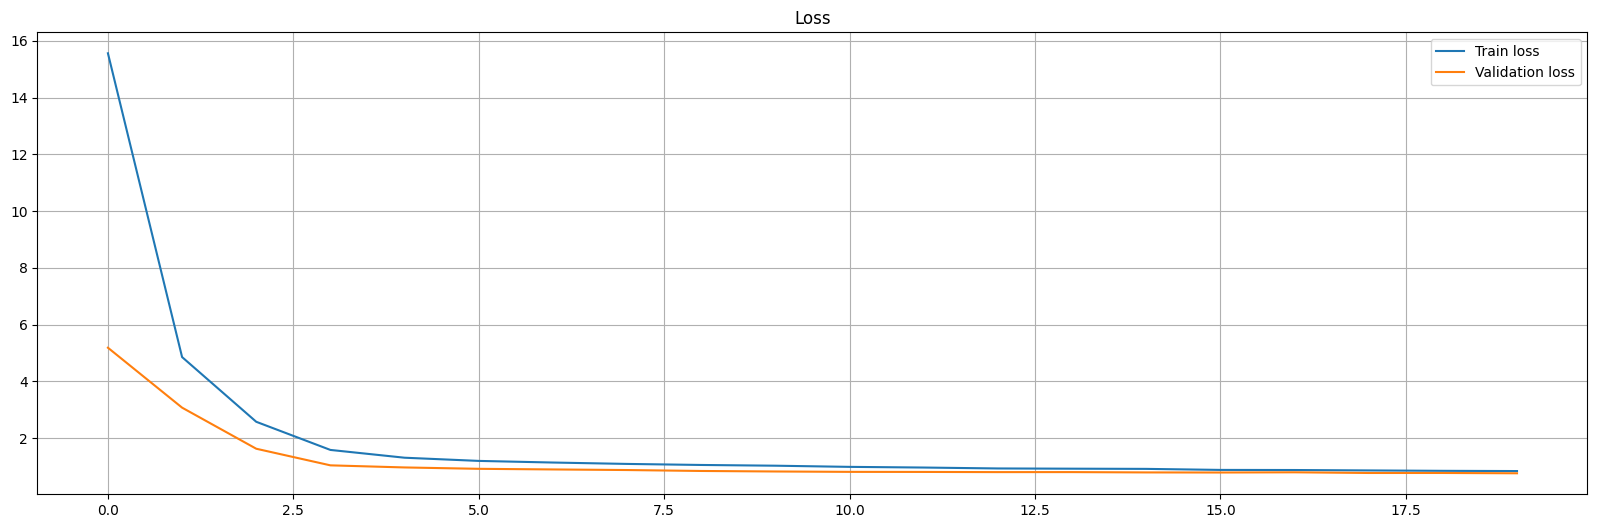

In [12]:
EPOCHS = 20
trainer= Trainer(model=model,
                 train_loader=train_loader,
                 valid_loader=valid_loader,
                 optimizer=optimizer)
trainer.train(EPOCHS)
trainer.plot()

### Inference with your fine-tuned model

Load the image that you want to test

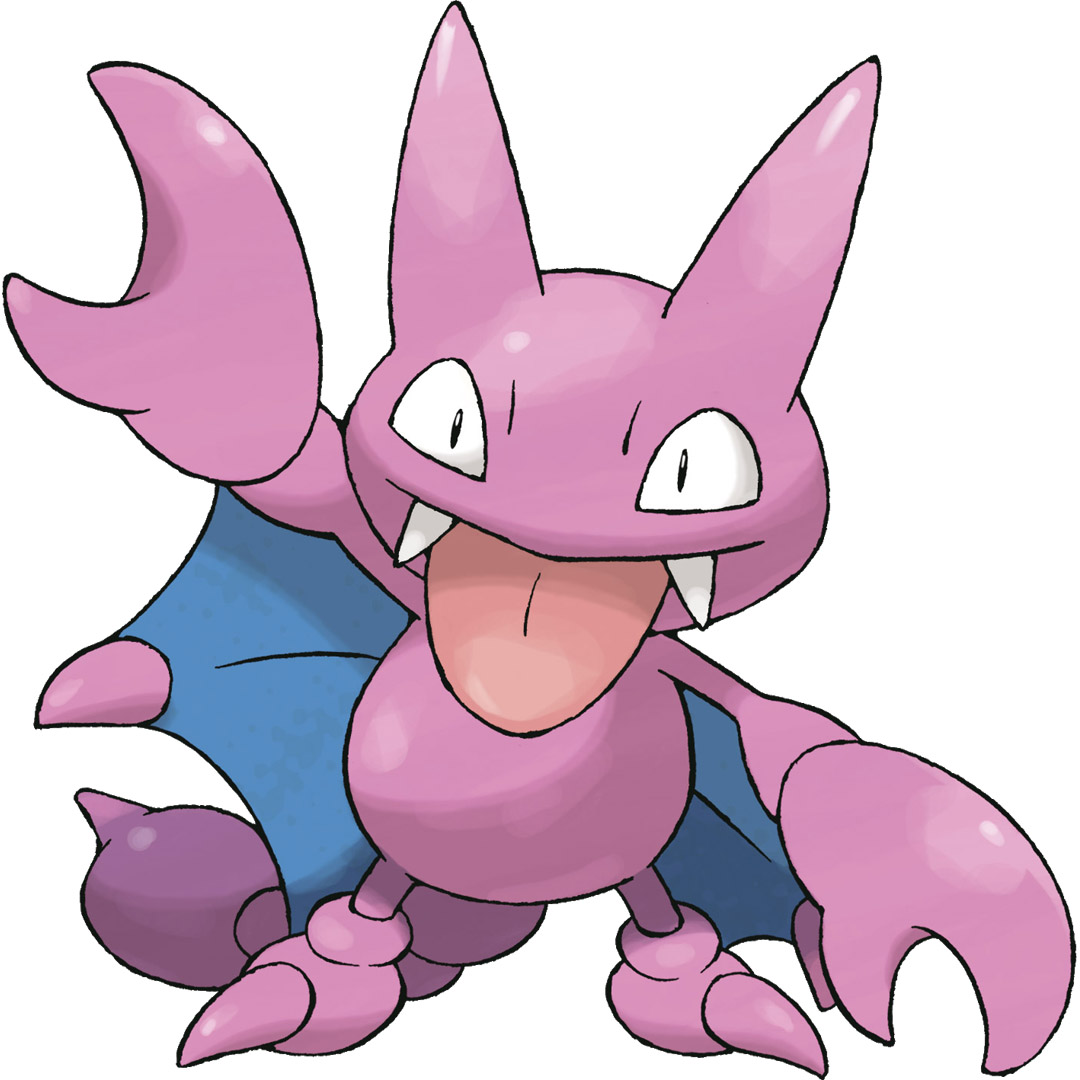

In [15]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [16]:
generated_caption = trainer.inference(image, processor)
print(generated_caption)

['a drawing of a cartoon character with a hat on']
